In [31]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

# load datasets

In [32]:
data = pd.read_csv('../data/datasets_processed/OpenPBTA_data_mean.csv', index_col='Unnamed: 0', dtype = 'unicode')
data = data.T.reset_index().rename(columns = {'index' : 'node'})
response = pd.read_csv('../data/datasets_processed/OpenPBTA_response.csv', index_col='Kids_First_Biospecimen_ID')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

# preprocess

In [33]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_OpenPBTA.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [43]:
L_norm_dagger = scipy.linalg.pinv(L_norm.toarray())

In [34]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response.values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L
L_norm_dagger = scipy.linalg.pinv(L_norm.toarray())

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [35]:
# define training params #RERUN WITH SOLVER PARAMS
alpha_list = np.logspace(-1,0,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
solver_params = {'max_iters':50000}
solver = cp.SCS

# Lasso 

In [15]:
VanillaLasso = LaplacianRegression('Lasso')
VanillaLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=None,
                 max_features=max_features, solver=solver, solver_params = solver_params, 
                 force_features=True, verbose=True, n_jobs=15)

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done 142 out of 150 | elapsed: 162.8min remaining:  9.2min
[Parallel(n_jobs=80)]: Done 150 out of 150 | elapsed: 163.6min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 21084417
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 65788, constraints m = 66427
Cones:	linear vars: 65786
	soc vars: 641, soc blks: 2
Setup time: 1.87e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.38e+21  3.56e+21  1.00e+00 -1.20e+23  2.81e+21  9.17e+21  2.60e-01 
   100| 1.96e-03  5.30e-02  4.58e-02  2.26e+00  2.01e+00  2.48e-15  9.95e+00 
   200| 8.83e-04  2.01e-02  1.86e-02  2.23e+00  2.33e+00  2.66e-15  1.94e+01 
   300| 

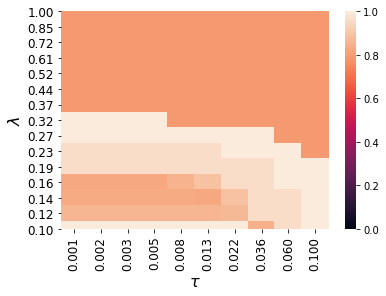

In [16]:
VanillaLasso.plotgridsearch()

In [17]:
print('Test MSE : ' ,VanillaLasso.predict(X_test, y_test))

Test MSE :  0.8303222908336825


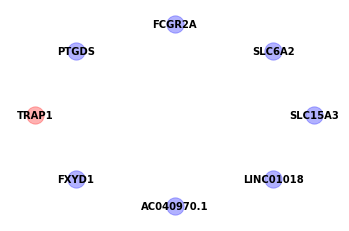

In [18]:
getTranslatedNodes(VanillaLasso.feats_, VanillaLasso.regr_.coef_, num_to_node, g,)

# NTF-Lasso

In [6]:
NTFLasso = LaplacianRegression('Lasso')
NTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm, 
             max_features=max_features, solver=solver, solver_params=solver_params,
             force_features=True, verbose=True, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed: 194.8min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 23503281
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 65788, constraints m = 66427
Cones:	linear vars: 65786
	soc vars: 641, soc blks: 2
Setup time: 7.08e+02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.38e+21  3.64e+21  1.00e+00 -2.74e+23  6.22e+21  2.10e+22  8.60e-01 
   100| 2.58e-03  6.15e-02  6.06e-02  5.22e+00  5.96e+00  1.13e-14  5.18e+01 
   200| 1.46e-03  4.55e-02  6.57e-02  4.95e+00  5.71e+00  4.60e-15  1.03e+02 
   300| 

  9600| 9.65e-06  7.61e-04  1.48e-03  4.95e-01  4.92e-01  2.49e-15  4.75e+03 
  9700| 1.40e-05  4.30e-04  6.66e-04  4.95e-01  4.97e-01  1.54e-16  4.80e+03 
  9800| 8.42e-06  8.20e-04  2.46e-03  4.96e-01  5.01e-01  8.72e-15  4.86e+03 
  9900| 5.19e-06  5.43e-04  1.42e-03  4.95e-01  4.92e-01  6.84e-15  4.91e+03 
 10000| 1.25e-05  3.40e-04  2.01e-05  4.94e-01  4.94e-01  2.91e-15  4.96e+03 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 4.96e+03s
	Lin-sys: nnz in L factor: 133175876, avg solve time: 4.76e-01s
	Cones: avg projection time: 5.44e-05s
	Acceleration: avg step time: 9.77e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.5527e-15, dist(y, K*) = 1.3878e-17, s'y/|s||y| = 7.8736e-19
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2480e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.4038e-04
rel gap:    |c'x + b

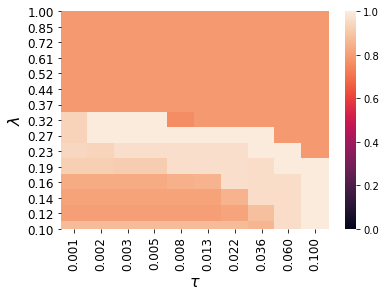

In [7]:
NTFLasso.plotgridsearch()

In [8]:
print('Test MSE : ' ,NTFLasso.predict(X_test, y_test))

Test MSE :  0.7630795955235844


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


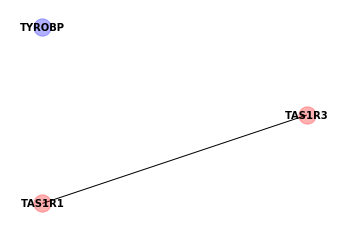

In [9]:
getTranslatedNodes(NTFLasso.feats_, NTFLasso.regr_.coef_, num_to_node, g)

# Ridge

In [24]:
VanillaRidge = LaplacianRegression('Ridge')
VanillaRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=None,
                 max_features=max_features, solver=solver, solver_params=solver_params, 
                 force_features=True, verbose=True, n_jobs=15)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 20985742
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32897, constraints m = 33538
Cones:	soc vars: 33538, soc blks: 4
Setup time: 2.82e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.54e+21  4.14e+20  1.00e+00 -5.15e+20  5.98e+19  1.52e+20  3.05e-01 
    80| 4.81e-11  3.30e-10  1.91e-10  2.03e-02  2.03e-02  2.15e-17  1.42e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solv

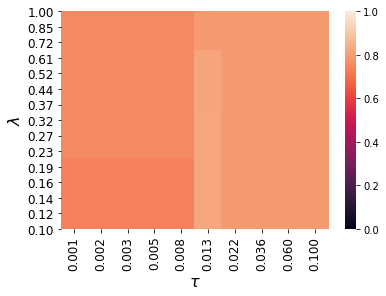

In [25]:
VanillaRidge.plotgridsearch()

In [26]:
print('Test MSE : ' ,VanillaRidge.predict(X_test, y_test))

Test MSE :  0.7349920798714362


/home/gokamath/anaconda3/envs/py373/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


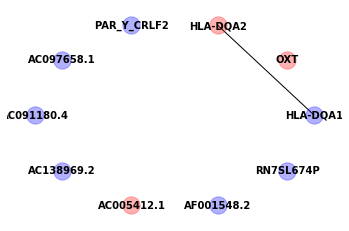

In [73]:
getTranslatedNodes(VanillaRidge.feats_, VanillaRidge.regr_.coef_, num_to_node, g,)

# NTF-Ridge

In [46]:
NTFRidge = LaplacianRegression('Ridge')
NTFRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm,
             max_features=max_features, solver=solver, solver_params=solver_params,
             force_features=True, verbose=True, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed: 484.2min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 277704781
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 32896, constraints m = 33534
Cones:	soc vars: 33534, soc blks: 3
Setup time: 3.95e+03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.23e+20  8.90e+19  1.00e+00 -5.06e+19  5.25e+18  1.26e+20  3.95e+00 
    40| 2.74e-09  8.89e-11  3.33e-11  1.73e-02  1.73e-02  3.36e-18  5.31e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Sol

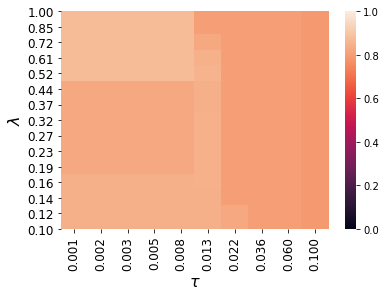

In [49]:
NTFRidge.plotgridsearch()

In [50]:
print('Test MSE : ' ,NTFRidge.predict(X_test, y_test))

Test MSE :  0.8016145998803352


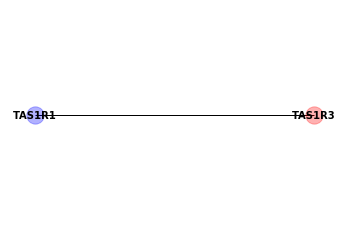

In [48]:
getTranslatedNodes(NTFRidge.feats_, NTFRidge.regr_.coef_, num_to_node, g, )

# TF-Lasso (Graph TF)

In [ ]:
TFLasso = LaplacianRegression('Lasso')
TFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L,
            max_features=max_features, solver=solver, solver_params=solver_params,
            force_features=True, verbose=True, n_jobs=8)

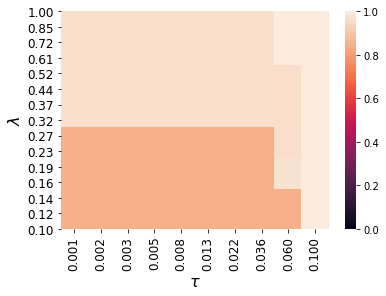

In [13]:
TFLasso.plotgridsearch()

In [14]:
print('Test MSE : ' ,TFLasso.predict(X_test, y_test))

Test MSE :  0.8508748874905259


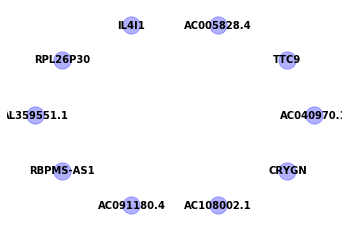

In [15]:
getTranslatedNodes(TFLasso.feats_, TFLasso.regr_.coef_, num_to_node, g,)

# Nonconvex Penalties (MCP, SCAD)

Training is over.
Test MSE :  0.9325904876230542


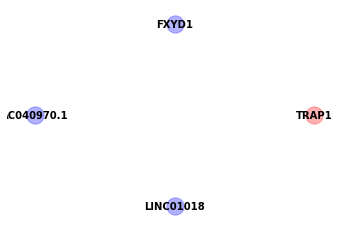

In [27]:
MCP = NonConvexRegression(penalty ='mcp')
MCP.fit(X_train, y_train, X_train, y_train, X_test, y_test, 
        alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,MCP.predict(X_test, y_test))
getTranslatedNodes(MCP.feats_, MCP.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_MCP.png')

Training is over.
Test MSE :  0.8098415382250783


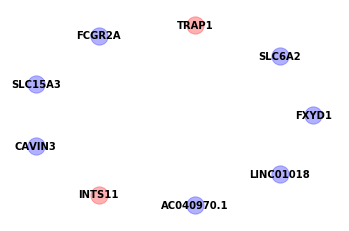

In [28]:
SCAD = NonConvexRegression(penalty = 'scad')
SCAD.fit(X_train, y_train, X_train, y_train, X_test, y_test, 
         alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,SCAD.predict(X_test, y_test))
getTranslatedNodes(SCAD.feats_, SCAD.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_SCAD.png')

# NTF-Nonconvex Penalties (NTF-MCP, NTF-SCAD) 

In [29]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

Training is over.
Test MSE :  0.7334089272390887


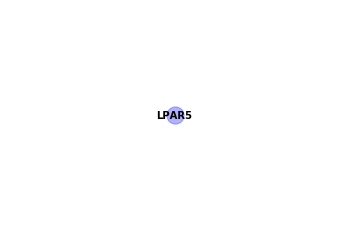

In [32]:
NTFMCP = NonConvexRegression(penalty ='mcp')
NTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test,
           alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,NTFMCP.predict(X_test, y_test))
getTranslatedNodes(NTFMCP.feats_, NTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_NTF-MCP.png')

Training is over.
Test MSE :  0.7528102744061814


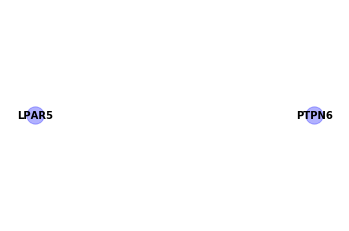

In [33]:
NTFSCAD = NonConvexRegression(penalty ='scad')
NTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
            alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,NTFSCAD.predict(X_test, y_test))
getTranslatedNodes(NTFSCAD.feats_, NTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_NTF-SCAD.png')

# Shuffled Features

In [36]:
# scramble feature order
random.seed(42)
feat_idx = list(range(X.shape[1]))
random.shuffle(feat_idx)
X_shuf = deepcopy(X[:,feat_idx])

# split for training
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [ ]:
ShuffledNTFLasso = LaplacianRegression('Lasso')
ShuffledNTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm, 
                     max_features=max_features, solver=solver, solver_params=solver_params, 
                     force_features=True, verbose=False, n_jobs=1)
print('Test MSE : ' ,ShuffledNTFLasso.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFLasso.feats_, ShuffledNTFLasso.regr_.coef_, num_to_node, g, save_location=None)

Test MSE :  0.8016145998803352


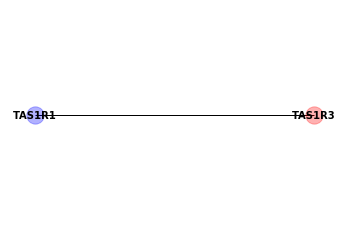

In [41]:
print('Test MSE : ' ,ShuffledNTFLasso.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFLasso.feats_, ShuffledNTFLasso.regr_.coef_, num_to_node, g, save_location=None)

Training is over.
Test MSE :  0.9116722609149821


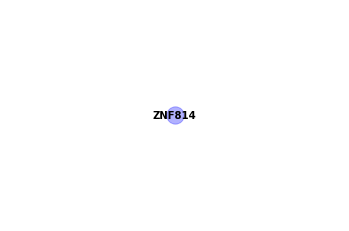

In [44]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

ShuffledNTFMCP = NonConvexRegression(penalty ='mcp')
ShuffledNTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
                   alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,ShuffledNTFMCP.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFMCP.feats_, ShuffledNTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_NTF-MCPshuf.png')

Training is over.
Test MSE :  0.759413700784938


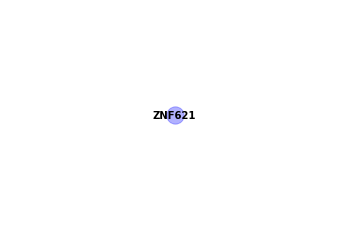

In [45]:
ShuffledNTFSCAD = NonConvexRegression(penalty ='scad')
ShuffledNTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test,
                    alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,ShuffledNTFSCAD.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFSCAD.feats_, ShuffledNTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/OpenPBTA_NTF-SCADshuf.png')

#### Elapsed time

In [16]:
print( 'Elapsed Time : ', time.time() - start_time)

Elapsed Time :  134899.9803097248
